# SKIN DISEASE PREDICTION
## Architect : Resnet50
## Dataset : HAM10000

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
%matplotlib inline     
!pip install "torch==1.4" "torchvision==0.5 " # To avoid warning error for each and every image in the dataset 

     |████████████████████████████████| 753.4MB 21kB/s 
     |████████████████████████████████| 4.0MB 19.8MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


### Importing the necessary packages

In [0]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import os
import io
import tarfile
import numpy as np
import PIL
import seaborn as sns




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Kaggle API, which is used to download the dataset from kaggle directly to colab 

In [0]:
os.environ['KAGGLE_USERNAME'] = "anjana22"
os.environ['KAGGLE_KEY'] = "16acf05db0477eb1236698f72ea68121"

### Downloading the  dataset from kaggle 

In [0]:
!kaggle datasets download -d tsaideepak/skincancer

 99% 457M/462M [00:10<00:00, 39.5MB/s]
100% 462M/462M [00:10<00:00, 47.6MB/s]


### unziping the downloaded zip file

In [0]:
!unzip -q skincancer.zip

In [0]:
sPath = Path("/content/datatree/train")

### No of classes in the dataset 

In [0]:
classes = os.listdir("/content/datatree/train")
print(classes)

['df', 'vasc', 'nv', 'bkl', 'bcc', 'mel', 'akiec']


### Checks ofr nana values in the dataset and deletes it 

In [0]:
for c in classes:
  verify_images(sPath/c, delete = True, max_workers=16)

### Splitting train and validation set

In [0]:
np.random.seed(8)
src = (ImageList.from_folder(sPath)
  .split_by_rand_pct(valid_pct = 0.2)
  .label_from_folder())

### Data Augumentation 

In [0]:

tfdm = get_transforms(max_rotate = 25, max_zoom = 1.3, max_warp = 0.4)

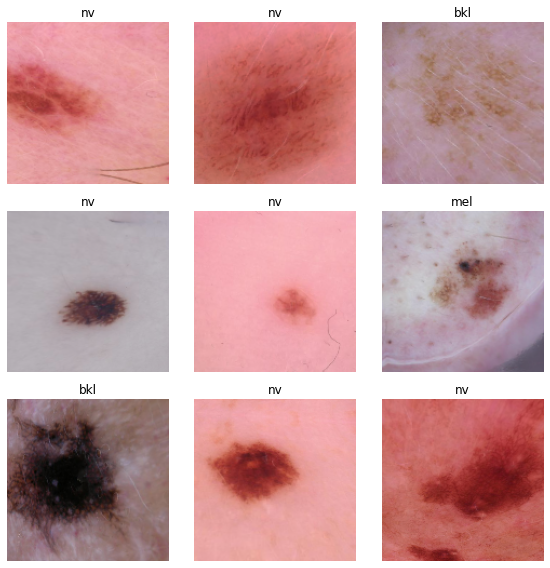

In [0]:
  data = (src.transform(tfdm,size = 150)
    .databunch(bs = 124) # initializing the batch size
    .normalize(imagenet_stats))# normalizing 
  data.show_batch(rows = 3, figsize = (8,8))

### Downloading a Pre-trained model 

In [0]:
learner50 = cnn_learner(data, models.resnet50, metrics = accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


### A trail run to find the most appropriate learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


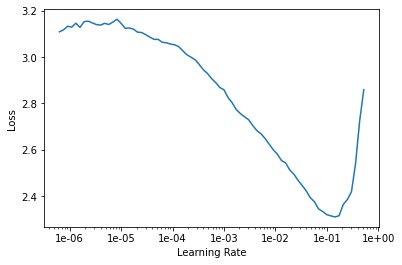

In [0]:
learner50.lr_find()
learner50.recorder.plot()

In [0]:
lr = 1e-02

### Training starts 

In [0]:
learner50.fit_one_cycle(10, max_lr =slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.957333,1.304661,0.678750,02:09
1,1.273871,0.743658,0.748125,02:05
2,0.956650,0.699496,0.750625,02:05
3,0.797674,0.597204,0.789375,02:05
4,0.696314,0.582422,0.791875,02:04
5,0.614487,0.559734,0.803125,02:04
6,0.555274,0.533615,0.809375,02:04
7,0.497298,0.522421,0.805625,02:04
8,0.464781,0.500112,0.815625,02:05
9,0.442373,0.498877,0.815000,02:05


### Acuracy on a pre-trained model is 81%

### Loss analyzing 

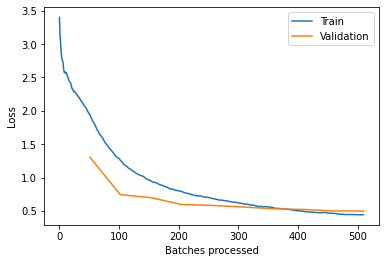

In [0]:
learner50.recorder.plot_losses()

In [0]:
learner50.save('/content/drive/My Drive/skin_disease_prediction/resenet50-prototype1')

In [0]:
interp = ClassificationInterpretation.from_learner(learner50)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)


True

### Visualizing the wrongly predicted images

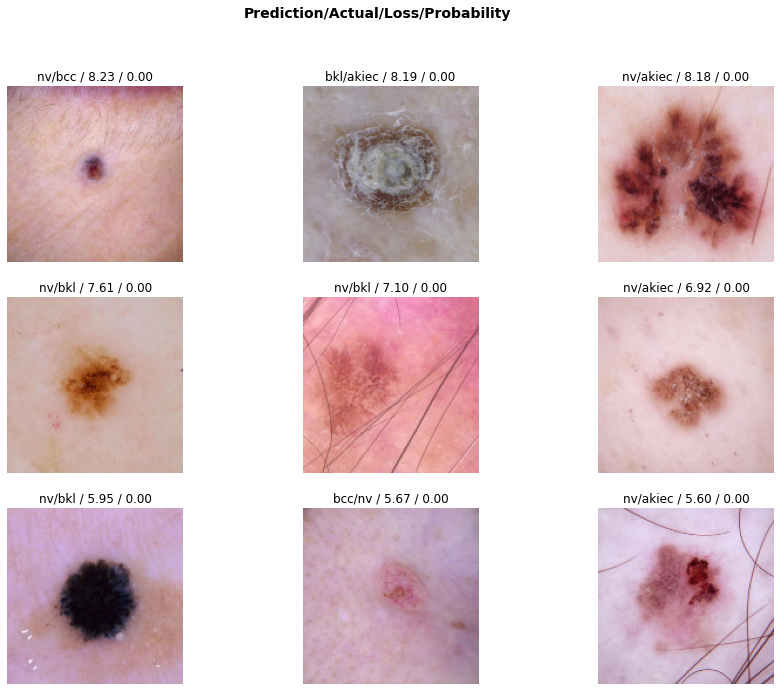

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

### Visualization of the algorithm's performance

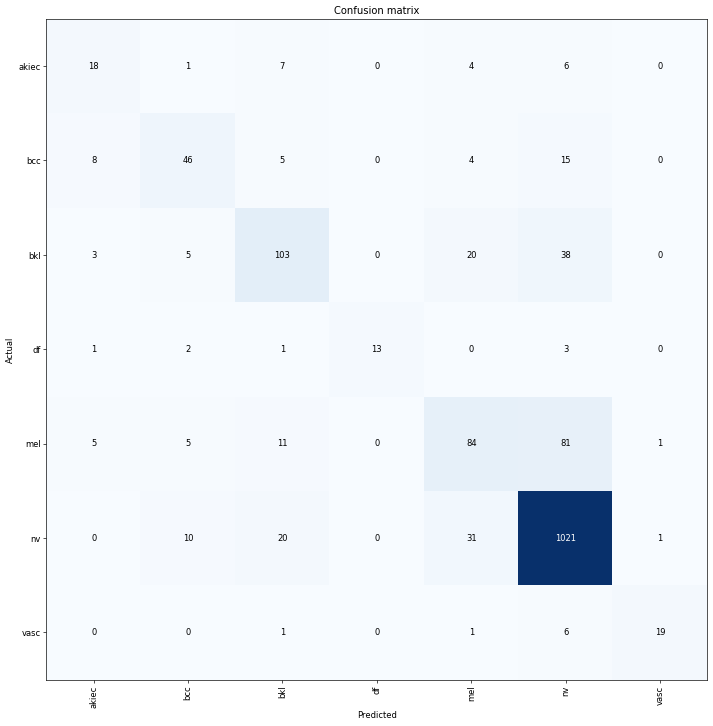

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### List of Confused classes

In [0]:
interp.most_confused(min_val=2)


[('mel', 'nv', 81),
 ('bkl', 'nv', 38),
 ('nv', 'mel', 31),
 ('bkl', 'mel', 20),
 ('nv', 'bkl', 20),
 ('bcc', 'nv', 15),
 ('mel', 'bkl', 11),
 ('nv', 'bcc', 10),
 ('bcc', 'akiec', 8),
 ('akiec', 'bkl', 7),
 ('akiec', 'nv', 6),
 ('vasc', 'nv', 6),
 ('bcc', 'bkl', 5),
 ('bkl', 'bcc', 5),
 ('mel', 'akiec', 5),
 ('mel', 'bcc', 5),
 ('akiec', 'mel', 4),
 ('bcc', 'mel', 4),
 ('bkl', 'akiec', 3),
 ('df', 'nv', 3),
 ('df', 'bcc', 2)]

### Unfreezing the layers of the pre-trained model to get trained on our dataset 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


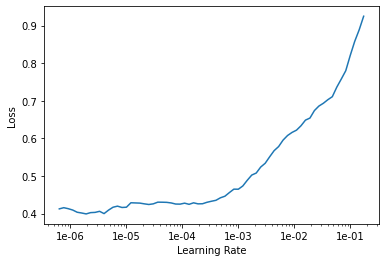

In [0]:
learner50.unfreeze()
learner50.lr_find() # To find the most appropriate learning rate
learner50.recorder.plot()

### Training the entire layers of the architecture

In [0]:
learner50.fit_one_cycle(3, max_lr = slice(1e-4, lr/4))

epoch,train_loss,valid_loss,accuracy,time
0,0.576541,0.876795,0.760625,02:12
1,0.541571,0.503058,0.823125,02:11
2,0.442065,0.433988,0.843750,02:11


In [0]:
learner50.save('/content/drive/My Drive/skin_disease_prediction/resnet50_prototype-2')

### Accuracy on the Transfer-learning model is 83%

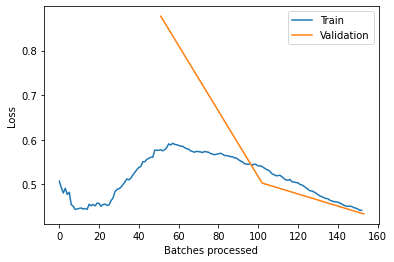

In [0]:
learner50.recorder.plot_losses() #loss visualization


In [0]:

interp = ClassificationInterpretation.from_learner(learner50)


In [0]:
interp.most_confused(min_val=1) #list of wrongly predicted classes 


[('mel', 'nv', 72),
 ('bkl', 'nv', 32),
 ('nv', 'mel', 24),
 ('bkl', 'mel', 19),
 ('nv', 'bkl', 17),
 ('bcc', 'nv', 13),
 ('bcc', 'akiec', 8),
 ('nv', 'bcc', 8),
 ('mel', 'bkl', 7),
 ('akiec', 'bkl', 6),
 ('akiec', 'mel', 6),
 ('bkl', 'bcc', 5),
 ('akiec', 'nv', 4),
 ('akiec', 'bcc', 3),
 ('bcc', 'mel', 3),
 ('mel', 'akiec', 3),
 ('mel', 'bcc', 3),
 ('bcc', 'bkl', 2),
 ('bcc', 'df', 2),
 ('df', 'akiec', 2),
 ('df', 'nv', 2),
 ('nv', 'vasc', 2),
 ('akiec', 'df', 1),
 ('bkl', 'df', 1),
 ('df', 'bkl', 1),
 ('df', 'mel', 1),
 ('nv', 'df', 1),
 ('vasc', 'bcc', 1),
 ('vasc', 'nv', 1)]

### Prediction over the test data

In [0]:
test_path = '/content/datatree/validation/'


In [0]:
test_Data = (ImageList.from_folder(test_path)
       .split_by_rand_pct(valid_pct=0.2)
       .label_from_folder()
       .transform(size=150)
       .databunch(bs=64))


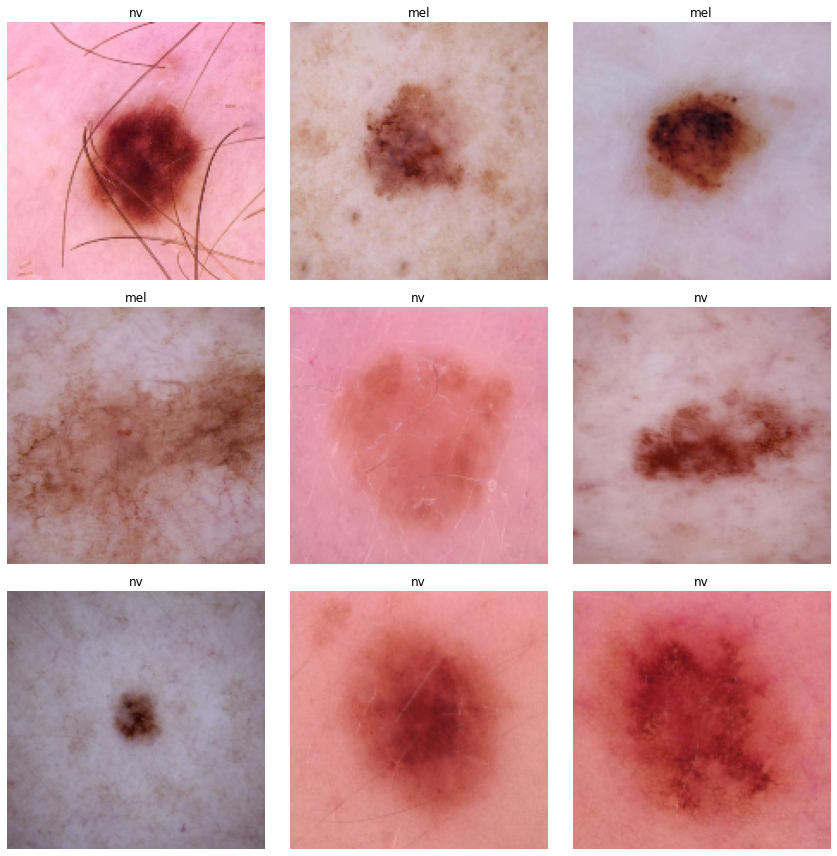

In [0]:
test_Data.show_batch(rows=3)


In [0]:
pred, y = learner50.get_preds()


In [0]:
pred

tensor([[6.7244e-07, 8.6962e-08, 2.3587e-04,  ..., 5.0837e-05, 9.9971e-01,
         1.0091e-07],
        [3.8125e-05, 2.9961e-05, 2.9698e-03,  ..., 1.0194e-02, 9.8675e-01,
         6.6476e-06],
        [1.0955e-02, 5.9743e-04, 3.9945e-02,  ..., 6.5003e-01, 2.9786e-01,
         1.0684e-04],
        ...,
        [1.3131e-03, 1.3393e-04, 1.4958e-02,  ..., 9.7083e-01, 1.2715e-02,
         4.0467e-06],
        [4.6467e-06, 2.2050e-06, 1.0977e-04,  ..., 1.1782e-03, 9.9870e-01,
         5.9567e-08],
        [6.2496e-04, 7.1309e-05, 5.7007e-03,  ..., 1.7379e-01, 8.1979e-01,
         9.5263e-06]])

In [0]:
y

tensor([5, 4, 4,  ..., 4, 5, 4])

In [0]:
pred = pred.argmax(dim = 1)

In [0]:
pred

tensor([5, 5, 4,  ..., 4, 5, 5])

### Different classes available under the test folder

In [0]:
test_Data.classes

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [0]:
from sklearn.metrics import classification_report

print(classification_report(y, pred))


              precision    recall  f1-score   support

           0       0.55      0.44      0.49        36
           1       0.71      0.64      0.68        78
           2       0.77      0.66      0.71       169
           3       0.74      0.70      0.72        20
           4       0.66      0.55      0.60       187
           5       0.89      0.95      0.92      1083
           6       0.93      0.93      0.93        27

    accuracy                           0.84      1600
   macro avg       0.75      0.70      0.72      1600
weighted avg       0.83      0.84      0.84      1600



### Testing a model with a newer image from different distribution

In [0]:
learner50.export()

In [0]:
defaults.device = torch.device('cpu')

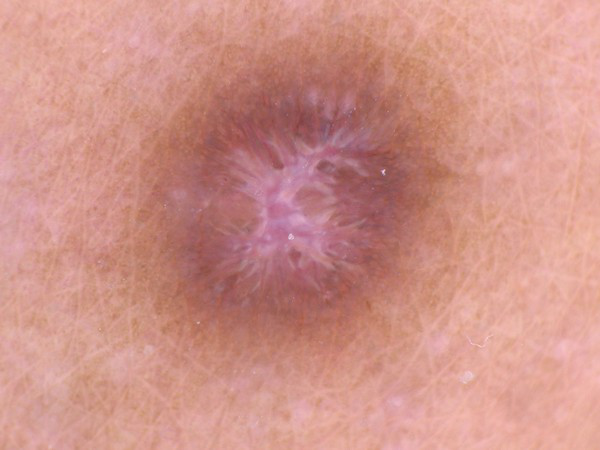

In [0]:
img = open_image("/content/1_R6N4Bi2slLO0p59g41dCcQ.jpeg")
img

In [0]:
learner50 = load_learner(sPath)

In [0]:
pred_class,pred_idx,outputs = learner50.predict(img)
if(pred_class == tensor(0)):
  print("Actinic Keratoses")
elif(pred_class == tensor(1)):
  print("Basal cell carcinoma")
elif(pred_class == tensor(2)):
  print("Benign keratosis")
elif(pred_class == tensor(3)):
  print("Dermatofibroma")
elif(pred_class == tensor(4)):
  print("Melanoma")
elif(pred_class == tensor(5)):
  print("Melanocytic nevi ")
elif(pred_class == tensor(6)):
  print("Vascular skin lesions ")

Dermatofibroma
